In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing

sns.set_style("white")

FEATURE_LIST = ['created_at', 'id', 'full_text', 'user', 'retweet_count', 'favorite_count', 'coordinates', 'place', 'class']
N_BINS = 18
IMAGE_PATH = 'images/'

In [3]:
training_set = pd.read_json('development.jsonl', lines=True)
training_set = training_set[FEATURE_LIST]

#test_set = pd.read_json('evaluation.jsonl', lines=True)
#test_set = test_set[feature_list]

In [34]:
n_positive = training_set.loc[training_set['class'] == 1, 'class'].count()
n_negative = training_set.loc[training_set['class'] == 0, 'class'].count()

n_null_coord = training_set['coordinates'].isna().sum()
n_null_place = training_set['place'].isna().sum()

# number of tweets with 0 as 'favorite_count'
n_pos_favcount = training_set.loc[(training_set['class'] == 0) & (training_set['favorite_count'] == 0), 'favorite_count'].count() / len(training_set) * 100
n_neg_favcount = training_set.loc[(training_set['class'] == 1) & (training_set['favorite_count'] == 0), 'favorite_count'].count() / len(training_set) * 100

median_neg_retweet = training_set.loc[training_set['class'] == 0, 'retweet_count'].median()
median_pos_retweet = training_set.loc[training_set['class'] == 1, 'retweet_count'].median()

median_neg_favcount = training_set.loc[training_set['class'] == 0, 'favorite_count'].median()
median_pos_favcount = training_set.loc[training_set['class'] == 1, 'favorite_count'].median()

tweet_len = [len(tweet) for tweet in training_set['full_text']]
training_set['tweet_len'] = tweet_len

median_pos_len = training_set.loc[training_set['class'] == 1, 'tweet_len'].median()
median_neg_len = training_set.loc[training_set['class'] == 0, 'tweet_len'].median()

print("Number of positive  tweets: {} ({:.2f}%), number of negative tweets: {} ({:.2f}%)".format(n_positive, n_positive / len(training_set) * 100, n_negative,  n_negative / len(training_set) * 100,))
print("Percentage of null coordinates: {:.2f}%, percentage of null places: {:.2f}%".format(n_null_coord / len(training_set) * 100, n_null_place / len(training_set) * 100))
print("Percentage of tweets with 0 as 'favorite_count': {:.2f}% ({:.2f}% positive tweets - median at {:.2f}, {:.2f}% negative tweets - median at {:.2f})".format(n_pos_favcount + n_neg_favcount, n_pos_favcount, median_pos_favcount, n_neg_favcount, median_neg_favcount))
print("Median of positive retweet count: {:.0f}, median of negative retweet count: {:.0f}".format(median_pos_retweet, median_neg_retweet))
print("Median lenght of positive tweets: {:.0f}, median lenght of negative tweets: {:.0f}".format(median_pos_len, median_neg_len))

Number of positive  tweets: 39931 (49.91%), number of negative tweets: 40069 (50.09%)
Percentage of null coordinates: 99.85%, percentage of null places: 99.09%
Percentage of tweets with 0 as 'favorite_count': 86.83% (43.87% positive tweets - median at 0.00, 42.96% negative tweets - median at 0.00)
Median of positive retweet count: 137, median of negative retweet count: 928
Median lenght of positive tweets: 140, median lenght of negative tweets: 124


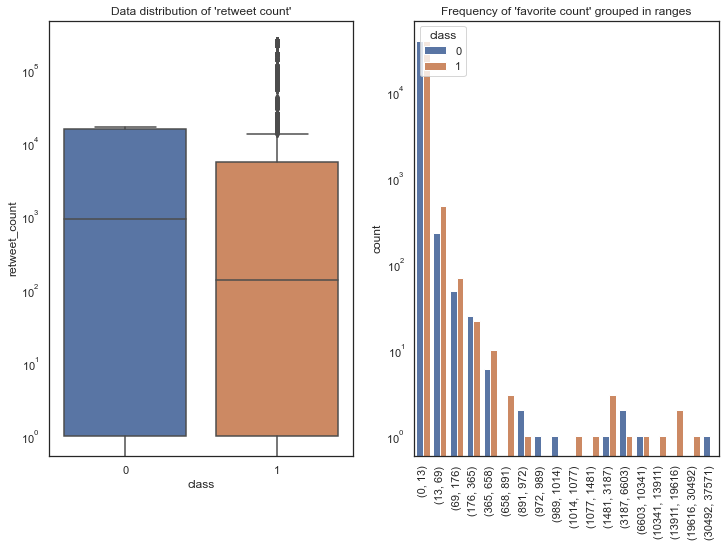

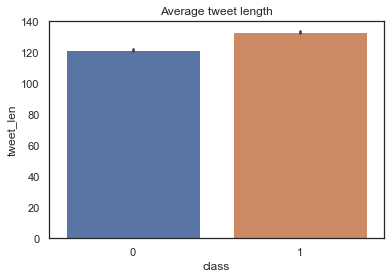

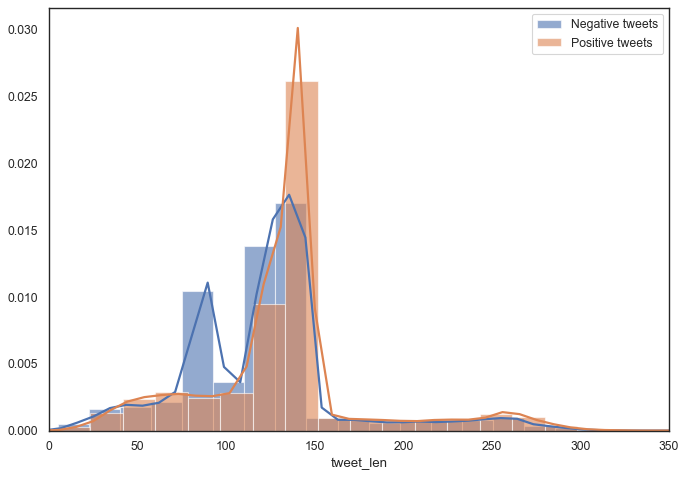

In [90]:
fig, axs = plt.subplots(ncols=2, figsize=(12,8))
g = sns.boxplot('class', 'retweet_count', data=training_set, ax=axs[0])
g.set_yscale('log')
axs[0].set_title("Data distribution of 'retweet count'")

fav_count = training_set['favorite_count'].to_numpy().reshape(-1,1)

discretizer = preprocessing.KBinsDiscretizer(n_bins=N_BINS, encode='ordinal', strategy='kmeans')
X_binned = discretizer.fit_transform(fav_count)
X_binned = np.reshape(X_binned, len(X_binned))

ranges = []
for i in range(len(discretizer.bin_edges_[0]) - 1):
    item = (int(discretizer.bin_edges_[0][i]), int(discretizer.bin_edges_[0][i+1]))
    ranges.append(item)

g = sns.countplot(X_binned, hue='class', data=training_set, ax=axs[1])
g.set_yscale('log')
g.set_xticklabels(ranges, rotation=90)
axs[1].set_title("Frequency of 'favorite count' grouped in ranges")

plt.savefig(IMAGE_PATH + 'distribution')
plt.show()

ax = plt.subplot()
ax.set_title("Average tweet length")
sns.barplot('class', 'tweet_len', data=training_set)
plt.savefig(IMAGE_PATH + 'tweet_len')

x1 = training_set.loc[training_set['class'] == 1, 'tweet_len']
x2 = training_set.loc[training_set['class'] == 0, 'tweet_len']

kwargs = dict(hist_kws={'alpha':.6}, kde_kws={'linewidth':2}, norm_hist=True)

plt.figure(figsize=(10,7), dpi= 80)

sns.distplot(x2, label="Negative tweets", **kwargs)
sns.distplot(x1, label="Positive tweets", **kwargs)

plt.xlim(0,350)
plt.legend()
plt.savefig(IMAGE_PATH + 'len_distrib')